# **Biomarker regions segmentation with 3D U-net**

### 1. Setup

In [16]:
!pip install --quiet --upgrade comet_ml python-dotenv nilearn torchio unet

import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import os
from comet_ml import Experiment
from dotenv import load_dotenv
import nilearn
from nilearn import plotting
import pandas as pd
from tqdm import tqdm
import warnings
from google.colab import drive

%load_ext autoreload
%autoreload 2
%matplotlib inline

[autoreload of utils.data failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Load environment variables from a file called `.env` 
# (its contents should be smth like "COMET_API_KEY=<your API key>")
load_dotenv()
### Variables I used:
# COMET_API_KEY - comet API key
# DATA_DIR - `anat` directory path in my Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 4. Writing dataloader

We will use `TorchIO` library: https://torchio.readthedocs.io/

In [14]:
from utils.data import read_data, prepare_batch, prepare_aseg, MRI, LABEL
from utils.vizualization import *
from torch.utils.data import DataLoader, Subset
from torchio import AFFINE, DATA, PATH, TYPE, STEM

In [21]:
data, subjects = read_data(training=True)
testing_data, testing_subjects = read_data(training=False)
crop = (49, 22, 49, 47, 19, 28)

[autoreload of utils.data failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]


  0%|          | 0/854 [00:00<?, ?it/s]

## 2. Whole brain segmentation

Let's define the experiment for whole brain segmentation:

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
from torch.utils.data import DataLoader, Subset
import torch.backends.cudnn as cudnn
from torch import optim
from utils.training import DiceLoss

import random
import numpy as np
import pandas as pd

import sys
import os
from optparse import OptionParser
import time

import torchio
from torchio import transforms

from IPython.display import clear_output
import matplotlib.pyplot as plt
from unet import UNet

from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit

import warnings
import multiprocessing

In [67]:
num_subjects = len(data)

training_split_ratio = 0.9

train_transform = transforms.Compose([
    # several_transforms,
    transforms.Crop(crop),
    transforms.Pad(4)
])

validation_transform = None

training_subjects, validation_subjects = train_test_split(
    subjects, train_size=training_split_ratio, shuffle=True, random_state=42
)

val_idxs = np.arange(0, len(data), 20).astype(int)
train_idxs = np.setdiff1d(np.arange(len(data)), val_idxs).astype(int)

training_subjects = np.take(subjects, train_idxs).tolist()
validation_subjects = np.take(subjects, val_idxs).tolist()

#training_subjects = subjects[:20]
#validation_subjects = subjects[20:40]

training_set = torchio.SubjectsDataset(
    training_subjects, transform=train_transform)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

testing_set = torchio.SubjectsDataset(
    testing_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Testing set:', len(testing_set), 'subjects')

Training set: 405 subjects
Validation set: 22 subjects
Testing set: 3 subjects


#### Defining the model and optimizer for training

At first check if we have GPU onborad:

In [57]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [58]:
def get_model_and_optimizer(device, num_encoding_blocks=4, out_channels_first_layer=8, patience=3):
    #Better to train with num_encoding_blocks >=3, out_channels_first_layer>=4 '''
    #repoducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
    model = UNet(
          in_channels=1,
          out_classes=6,
          dimensions=3,
          num_encoding_blocks=num_encoding_blocks,
          out_channels_first_layer=out_channels_first_layer,
          normalization='batch',
          upsampling_type='linear',
          padding=True,
          activation='PReLU',
      ).to(device)
      
    optimizer = torch.optim.AdamW(model.parameters())
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

# model, optimizer, scheduler = get_model_and_optimizer(device)

## 3. Patch-based segmentation

Let's fedine another experiment within the same workspace in `COMET ML`:

In [66]:

experiment = Experiment(
    project_name="neuroml-hw2",
    workspace="barahlush",
)

experiment.set_name("Base model, 6 classes, 4 encoding blocks, 8 out, Patch based, 64 batch, crop")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/barahlush/neuroml-hw2/916a880a7a92434c8be97e8fa6b15d68



In [55]:
#experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/barahlush/neuroml-hw2/03fa11c1b2f343b0a58ab0b8ebb1ab83
COMET INFO:   Metrics:
COMET INFO:     avg_val_dice : 0.08556292002851312
COMET INFO:   Others:
COMET INFO:     Name : Default experiment, 6 classes, 4 encoding blocks, 8 out, Patch based, 64 batch, crop
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (9.42 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before

In [68]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 4
num_training_workers = 8
num_validation_workers = 1

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
#     num_workers=num_training_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
#     num_workers=num_validation_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size, shuffle=False)

In [69]:
import SimpleITK as sitk
from collections import Counter
import enum
model_dir = 'checkpoints'

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def evaluate(model, evaluation_set, patch_size=64, patch_overlap=0):
    dice_scores = []
    iou_scores = []
    dice_loss = DiceLoss(6)
    
    for i in tqdm(range(len(evaluation_set)), leave=False):
        sample = evaluation_set[i]
        input_tensor = sample[MRI][DATA][0]
        targets = torch.from_numpy(
            prepare_aseg(sample[LABEL][DATA])
        
        )
        
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=validation_batch_size)
    
        aggregator = torchio.inference.GridAggregator(grid_sampler)
        
        model.eval()
        
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs = patches_batch[MRI][DATA].to(device)
                locations = patches_batch['location']
                logits = model(inputs.float())
        
                aggregator.add_batch(logits, locations)
            
            prediction = aggregator.get_output_tensor()            
            dice_loss_, dice_score_ = dice_loss(prediction.unsqueeze(0), 
                                                targets, 
                                                softmax=True)
            
            dice_scores.append(dice_score_)
            
    return {
        'dice': dice_scores
    }


def train(num_epochs, training_loader, validation_set, model, optimizer, scheduler=None,
          weights_stem='', patch_size=64, patch_overlap=0):
    
    scores = evaluate(model, validation_set, patch_size=patch_size, patch_overlap=patch_overlap)
    
    for key in scores:
        scores[key] = np.mean(scores[key])
        experiment.log_metric(f"avg_val_{key}", scores[key], step=0, epoch=0)
        
    best_dice = scores['dice']
    print(f"Validation mean score: DICE {scores['dice']:0.3f}", "by class:",scores[key] )    
    
    step_counter = Counter()
    torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}.pth'))
    for epoch_idx in range(1, num_epochs + 1):
        print('\nStarting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer, step_counter,
                  scheduler=scheduler)
        
        scores = evaluate(model, validation_set, patch_size=patch_size, patch_overlap=patch_overlap)
        for key in scores:
            scores[key] = np.mean(scores[key])
            experiment.log_metric(f"avg_val_{key}", scores[key], step=epoch_idx, epoch=epoch_idx)
            
        print(f"Validation mean score: DICE {scores['dice']:0.3f}")    
        
        avg_dice = scores['dice']
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}.pth'))
        
        
def run_epoch(epoch_idx, action, loader, model, optimizer, step_counter, scheduler=None):
    is_training = action == Action.TRAIN
    dice_loss = DiceLoss(6)
    epoch_losses = []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader, leave=False)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs.float())
            batch_losses, score_dice = dice_loss(logits, 
                                                 targets.squeeze(1), 
                                                 softmax=True)
            batch_loss = batch_losses.mean() 
            if is_training:
                batch_loss.backward()
                optimizer.step()
                
            epoch_losses.append(batch_loss.item())
            if action == Action.TRAIN:
                experiment.log_metric("train_dice_loss", batch_loss.item(),
                                      epoch=epoch_idx, step=step_counter[action])
            elif action == Action.VALIDATE:
                experiment.log_metric("val_dice_loss", batch_loss.item(),
                                      epoch=epoch_idx, step=step_counter[action])
            step_counter[action] += 1
    
    epoch_losses = np.array(epoch_losses)
    avg_loss = epoch_losses.mean()
    
    if action == Action.TRAIN:
        experiment.log_metric("avg_train_dice_loss", avg_loss, step=epoch_idx, epoch=epoch_idx)
        if scheduler:
            scheduler.step(avg_loss)
    
    elif action == Action.VALIDATE:
        experiment.log_metric("avg_val_dice", 1 - avg_loss, step=epoch_idx, epoch=epoch_idx)
    
    print(f'{action.value} mean loss: {avg_loss:0.3f}')
    return avg_loss


In [70]:
torch.cuda.empty_cache()

In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)

num_epochs = 10
weights_stem = '6_classes_4_blocks_8_chanels'

torch.manual_seed(42)
np.random.seed(42)

train(num_epochs, training_loader, validation_set, model, optimizer, scheduler,
      weights_stem=weights_stem, patch_overlap=0)

Validation mean score: DICE 0.086 by class: 0.08556292002851312

Starting epoch 1


Training mean loss: 0.491


Validation mean score: DICE 0.690

Starting epoch 2


 21%|██        | 43/203 [01:28<04:41,  1.76s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

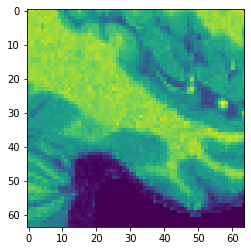

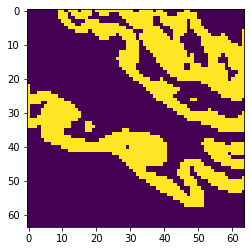

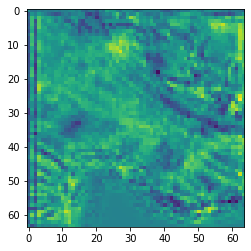

torch.Size([16, 1, 64, 64, 64]) torch.Size([16, 6, 64, 64, 64])
torch.Size([16, 64, 64, 64]) torch.Size([16, 6, 64, 64, 64])


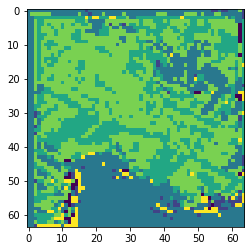

[0.31433534622192383, 0.07340216636657715, 0.04025423526763916, 0.04666447639465332, 0.0254785418510437, 0.2795277237892151]


In [68]:
# checking
enum = enumerate(tqdm(training_loader))
_, batch = next(enum)
inputs, targets = prepare_batch(batch, 'cuda:0')


plt.imshow(inputs.cpu()[2, 0, 32])
plt.show()
plt.imshow(targets.cpu()[2, 0, 32])
plt.show()

labels = model(inputs.float())
plt.imshow(labels.cpu().detach().numpy()[2, 0, 32])
plt.show()

print(targets.size(), labels.size())
dice_loss = DiceLoss(6)

dice_loss_, dice = dice_loss(labels, targets.squeeze(1), softmax=True)
print(targets.squeeze(1).size(), labels.size())

pred = labels.argmax(1,True) #([16, 2, 64, 64, 64])
plt.imshow(pred.cpu().numpy()[2,0, 32])
plt.show()

print(dice)

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_dir, f'model_{weights_stem}.pth'), map_location=device))
test_scores = evaluate(model, testing_set, patch_size=64, patch_overlap=0)
print(test_scores)
print(f"\nTesting mean score: DICE {np.mean(test_scores['dice']):0.3f}")  

In [ ]:
experiment.log_metric("avg_test_dice", np.mean(test_scores['dice']))
for i, subject in enumerate(test_subjects):
    experiment.log_metric(f"test_subj_{subject}_dice", np.mean(test_scores['dice'][i]))

In [ ]:
import nibabel as nib
sample = random.choice(validation_set)
input_tensor = sample[MRI][DATA][0]
patch_size = 64, 64, 64  # we can user larger or smaller patches for inference
patch_overlap = 20
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch[MRI][DATA].to(device)
#         print(inputs.unique())
        locations = patches_batch['location']
        logits = model(inputs.float())
        labels = logits.argmax(dim=1, keepdim=True)
        aggregator.add_batch(labels, locations)
        
plot_central_cuts(aggregator.get_output_tensor())

### Check the experiments with with different clasess, and baseline one:

**Baseline** - "6 classes, 4 encoding blocks, 8 out, Patch based, 64 batch, crop"
https://www.comet.ml/kondratevakate/mri-segmentation-2021/view/Q6KVHNSRxQ22hC0oM7NL1rF1B

### Extra part:
#### If you want to log your images, you may start with that code:

In [ ]:
from einops import rearrange
from torchvision.utils import make_grid

images_grid = []
val_dice = []
model.train(False)
dice_loss = DiceLoss(6)

for batch_idx, batch in enumerate(tqdm(validation_loader)):
    inputs, targets = prepare_batch(batch, device)
    batch_size, _, patch_d = inputs.shape[:3]

    with torch.no_grad():
        logits = model(inputs.float())
        probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
        
        for sample_idx in range(batch_size):
            # appending the predicted and gt picture (central slices)
            pred = 1 - torch.argmax(logits[sample_idx], dim=0)
            
            pred_slice = pred[patch_d // 2]
            gt_slice   = targets[sample_idx, 0, patch_d // 2]
            images_grid.append(make_grid([rearrange(pred_slice.float(), '(c h) w -> c h w',  c=1), 
                                          rearrange(gt_slice.float(), '(c h) w -> c h w', c=1)], 
                                         nrow=1))
            
            dice_loss_, sample_dice = dice_loss(logits,
                                                 targets.squeeze(1), 
                                                 softmax=True)
            
            val_dice.append(sample_dice)            
        
        del inputs, targets, logits, probabilities, sample_dice, pred
        
images_per_pic = 16

for i in range(0, len(images_grid), images_per_pic):
    grid_img = make_grid(images_grid[i:i + images_per_pic])
    grid_img = rearrange(grid_img.cpu().numpy(), 'c h w -> h w c')
    plt.figure(figsize=(20, 20))
    plt.imshow(grid_img)
    plt.show()
    experiment.log_image(grid_img, name='val patches (odd rows -- pred, even rows -- gt)')

Yes, you get a full solution it your hands, yet keep in mind - it is just your baseline. You should experiment with the augmentations, losses and build a story of your model development.